In [1]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

import pandas as pd
import numpy as np
from scipy.signal import argrelmax

import math
from itertools import takewhile

### General helper functions

In [2]:
def is_between(data, lower, upper):
    return np.logical_and(data >= lower, data < upper)

def between(data, lower, upper):
    return data[is_between(data, lower, upper)]

#TODO axis, more dimensions
def is_around(data, point, range):
    return is_between(data, point - range, point+range)
    
def around(data, point, range):
    return data[is_around(data, point, range)]

np.is_between = is_between
np.between    = between
np.is_around  = is_around
np.around     = around

In [3]:
def format_exp (number, decimals=2):
    def exp_(f):
        return int(math.floor(math.log10(abs(f)))) if f != 0 else 0
    
    exponent = exp_(number)
    mantissa = number / 10**exponent
    
    return "%%.%if" % decimals % mantissa + "$\\times 10^{%s}$" % exponent

### Reading data

In [4]:
def read_file(folder_name = "./", file_name="B4_nt_B4_t%i.csv", num_threads=4, column_names = ["Energy", "Track_length"]):
    file_name = folder_name + file_name
    
    data = pd.read_csv (file_name % 0, comment="#", header=None, names=column_names)
    for i in range(1, num_threads):
        data = data.append(pd.read_csv (file_name % i, comment="#", header=None, names=column_names))
    
    return data

In [5]:
def read_with_angle (dir_name, num_threads=4):
    data_with_angle = read_file(dir_name, column_names=["Energy", "Track_length", "p_X", "p_Y", "p_Z"], num_threads=num_threads)
    data_with_angle["angle"] = np.arccos(np.dot(data_with_angle[["p_X", "p_Y", "p_Z"]], [0,0,1]))
    return data_with_angle

In [12]:
def read_distance_folders (base_folder_name, dists, num_threads=4):
    datas = []
    
    for dist in dists:
        datas.append(read_with_angle (base_folder_name + "/%i/" % dist, num_threads=num_threads))
    
    return datas

In [6]:
def read_distance_vs_hits(base_folder_name="./distance", dists= list(range(0, 20)) + list(range(20, 100, 5)), num_threads=4):
    hits  = []
    
    for dist in dists:
        data = read_with_angle (base_folder_name + "/%i/" % dist, num_threads=num_threads)
        hits.append((data["Energy"] > data["Energy"].max() * 0.95).sum())
    return dists, hits

### Helper functions

In [266]:
def count_hit_ratio_around_peaks (data, peaks=table, radius = 0.005):
    hits_around_peak = []
    
    for _, (isotope, E, p, p_norm) in table.iterrows():
        hits_around_peak.append([E, np.is_around(data, E, radius).sum() / len(data)])
    
    return np.array(hits_around_peak)

In [7]:
def SimpleHistogram(X, name=None, plot_peaks=False, alpha=None, label=None, do_texts=True, bin_num=200):
    vals, bins, _ = plt.hist(X, bin_num, alpha=alpha, label=label);
    
    #ignore 0 and photopeak
    ylim  = vals[1:-1].max() * 1.1
    x_max = X.max()
    
    plt.ylim(0,ylim)
    plt.xlabel("E absorbed [MeV]")
    plt.ylabel("# of events")
    
    if do_texts:
        if bins[0] == 0:
            plt.text(0     + 0.005, ylim * 0.9, "<- %s" % format_exp(vals[0]),  horizontalalignment='left',  fontsize=8)
        
        if vals[-1] > ylim:
            plt.text(x_max - 0.005, ylim * 0.9, "%s ->" % format_exp(vals[-1]), horizontalalignment='right', fontsize=8)
    
    if plot_peaks:
        plot_peaks(bins[:-1], vals, ylim)
    
    if name:
        plt.savefig(name + ".svg")

In [8]:
def plot_peaks(x, y, ylim, diff=100, order=50):
    
    inds = argrelmax(y, order=order)[0]
    
    for ind in inds:
        plt.text(x[ind], min(y[ind], ylim)*0.9, "E = %.2f ->" % x[ind], horizontalalignment="right")

In [9]:
def plot_L_vs_E(data, name=None):
    plt.hist2d(data["Track_length"], data["Energy"], 50, norm=LogNorm());
    #plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().set_facecolor("lightgray")
    colbar = plt.colorbar();
    colbar.set_label("# of events")
    
    plt.xlabel("Track length [m]")
    plt.ylabel("E absorbed [MeV]")
    
    if name:
        plt.savefig(name + ".svg")

## Loading the gamma table

In [233]:
table = pd.read_csv("build/U_238.txt", delimiter="\t")
table["Norm_prob"] = table["Probability"] / table["Probability"].sum()

# Data analysis

In [48]:
data = read_file(column_names=["Energy", "Track_length", "p_X", "p_Y", "p_Z"])
data

,Energy,Track_length,p_X,p_Y,p_Z
0,1.000000,0.914596,0.000000,0.000000,1.000000
1,0.818028,1.045090,0.409069,-0.005816,-0.912485
2,0.694412,0.916748,0.901940,0.399254,-0.164624
3,0.556754,0.490054,0.627641,0.690259,0.360012
4,0.038119,0.008548,-0.195388,0.044323,0.979724
...,...,...,...,...,...
25419,1.000000,1.111440,0.000000,0.000000,1.000000
25420,0.353213,0.304353,-0.220131,-0.655663,0.722252
25421,0.245891,0.201651,-0.443040,0.383308,0.810426
25422,1.000000,1.007460,0.000000,0.000000,1.000000


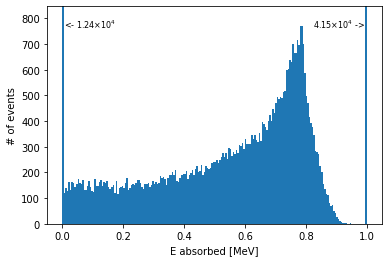

In [10]:
SimpleHistogram(data["Energy"])

(0, 1500)

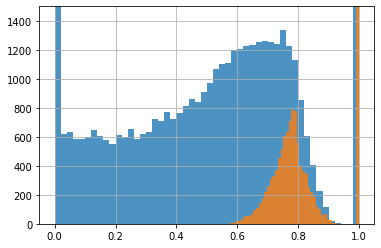

In [133]:
asd = data.groupby(pd.cut(data["Track_length"], [-np.inf, 0.8, np.inf]))
asd["Energy"].hist(stacked=True, alpha=0.8, bins=50)
plt.ylim(0, 1500)

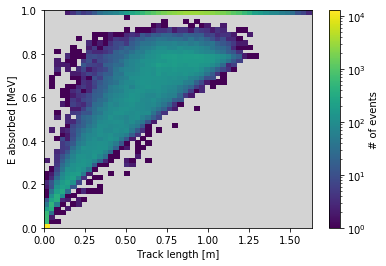

In [135]:
plot_L_vs_E(data)

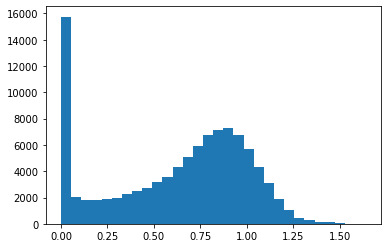

In [136]:
plt.hist(data["Track_length"], bins=30);

In [137]:
from scipy.stats import binned_statistic

avg, edges, _ = binned_statistic(data["Energy"], data["Track_length"], 'mean', bins=50)
x_ = edges[:-1]

/home/balazzs/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Average track length')

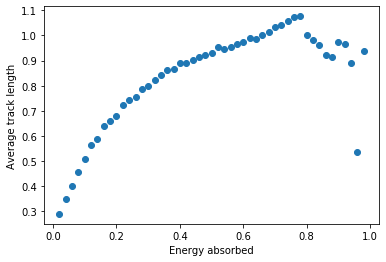

In [138]:
plt.plot(x_, avg/x_, "o")
plt.xlabel("Energy absorbed")
plt.ylabel("Average track length")

# Different physics

#### Penelope vs EmStandard (QBBC)

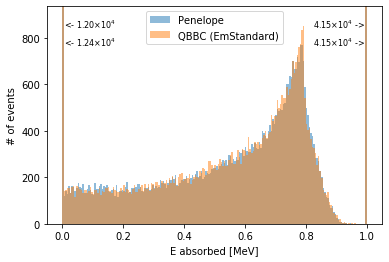

In [234]:
data_penelope = read_file("1MeV_cylinder_penelope/")
data_QBBC     = read_file("1MeV_cylinder_QBBC/")
SimpleHistogram(data_penelope["Energy"], alpha=0.5, label="Penelope")
SimpleHistogram(data_QBBC["Energy"]    , alpha=0.5, label="QBBC (EmStandard)")

plt.legend()

plt.savefig("physics_1MeV.svg")

#### Photoeffect on/off

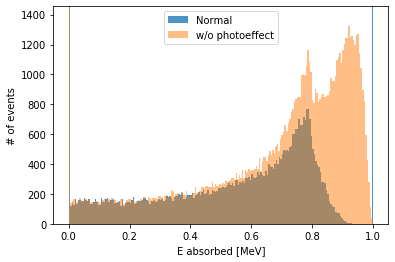

In [275]:
data_no_photo = read_file("1MeV_nophotoeffect_penelope/")
SimpleHistogram(data_penelope["Energy"], do_texts=False, alpha=0.8, label="Normal")
SimpleHistogram(data_no_photo["Energy"], do_texts=False, alpha=0.5, label="w/o photoeffect")
plt.legend();

plt.savefig("photoeffect.svg")

#### Penelope vs Livermore vs EmStandard

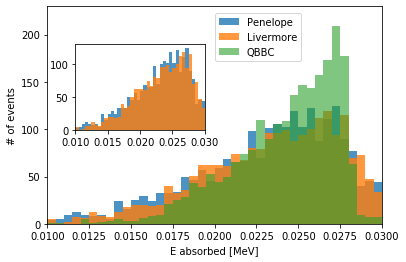

In [272]:
data_penelope_100kev  = read_file("100keV_penelope/")
data_QBBC_100kev      = read_file("100keV_QBBC/")
data_livermore_100kev = read_file("100keV_livermore/")

SimpleHistogram(data_penelope_100kev["Energy"] , do_texts=False, alpha=0.8, label="Penelope")
SimpleHistogram(data_livermore_100kev["Energy"], do_texts=False, alpha=0.8, label="Livermore")
SimpleHistogram(data_QBBC_100kev["Energy"]     , do_texts=False, alpha=0.6, label="QBBC")

plt.xlim(0.01, 0.03)
plt.legend(loc=(.5, .75))


left, bottom, width, height = [0.19, 0.45, 0.3, 0.3]
ax2 = plt.gcf().add_axes([left, bottom, width, height])
SimpleHistogram(data_penelope_100kev["Energy"] , do_texts=False, alpha=0.8, label="Penelope")
SimpleHistogram(data_livermore_100kev["Energy"], do_texts=False, alpha=0.8, label="Livermore")
plt.xlim(0.01, 0.03)
plt.ylabel("");
plt.xlabel("");

plt.savefig("physics_100keV.svg")

# Exit angle

## Absorbed energy angle dependence

In [67]:
def make_angle_vs_energy_plot (data):
    sub_data = data[np.logical_and(data["Energy"] != data["Energy"].max(), data["Energy"] != 0.0)]
    
    plt.hist2d(sub_data["angle"], sub_data["Energy"], bins=30, norm=LogNorm());
    cbar = plt.colorbar()
    
    plt.xlabel("Exit angle [rad]")
    plt.ylabel("Absorbed energy [MeV]")
    cbar.set_label("# of events")

In [98]:
data_10MeV_angle  = read_with_angle("exit_angle/10MeV/")
data_1MeV_angle   = read_with_angle("exit_angle/1MeV/")
data_511keV_angle = read_with_angle("exit_angle/511keV/")
data_250keV_angle = read_with_angle("exit_angle/250keV/")
data_100keV_angle = read_with_angle("exit_angle/100keV/")

In [297]:
#deposited energy in single Compton scattering (theroetical)
#E:     energy of photon
#theta: scattering angle
def e_dep(E, theta):
    m_e = 511e3
    return E * (1 - 1 / (1 + (E / m_e) * (1 - np.cos(theta))))

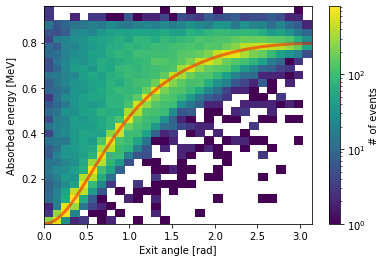

In [313]:
make_angle_vs_energy_plot(data_1MeV_angle)

X = np.linspace(0,3.14, 100)
plt.plot(X, e_dep(1e6, X)/1e6, color="red", alpha=0.5, lw=3)

plt.savefig("exit_angle_distribution.svg")

## Exit direction distribution

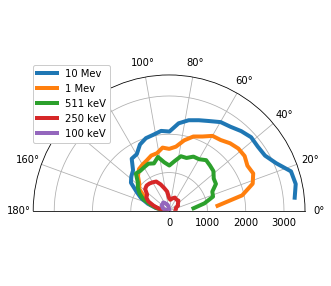

In [316]:
plt.figure(figsize=(5,5))

vals, bins = np.histogram(data_10MeV_angle["angle"], bins=30)
plt.polar(bins[1:-1], vals[1:], lw=4, label="10 Mev")
vals, bins = np.histogram(data_1MeV_angle["angle"], bins=30)
plt.polar(bins[1:-1], vals[1:], lw=4, label="1 Mev")
vals, bins = np.histogram(data_511keV_angle["angle"], bins=30)
plt.polar(bins[1:-1], vals[1:], lw=4, label="511 keV")
vals, bins = np.histogram(data_250keV_angle["angle"], bins=30)
plt.polar(bins[1:-1], vals[1:], lw=4, label="250 keV")
vals, bins = np.histogram(data_100keV_angle["angle"], bins=30)
plt.polar(bins[1:-1], vals[1:], lw=4, label="100 keV")

plt.gca().set_thetamax(180)
plt.yticks([0, 1000, 2000, 3000])
plt.legend(loc= (0.0, 0.5), framealpha=1);

plt.savefig("exit_angle_polar.svg", bbox_inches="tight")

# World changed to air from vacuum

# Particla gun -> source

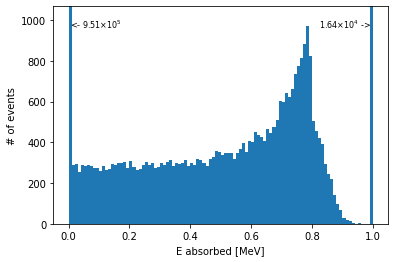

In [254]:
data_source = read_with_angle("distance/5/")
SimpleHistogram(data_source["Energy"], bin_num=100)

basically the same with radial distribution

# Distance

In [268]:
dists, hits = read_distance_vs_hits()

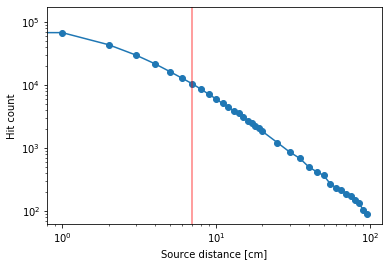

In [290]:
plt.plot(dists, hits, "o-")

detector_size = 7
plt.axvline(detector_size, color="red", alpha=0.5)

plt.yscale("log")
plt.xscale("log")
plt.xlabel("Source distance [cm]")
plt.ylabel("Hit count")
plt.savefig("distance_vs_hits.svg")

# Uranium gamma energy distribution

## From table

(probability of given energies given in a table; photons for events generated from the table)

In [173]:
data_U238_table = read_with_angle("data/uranium_table_simple_detector/")

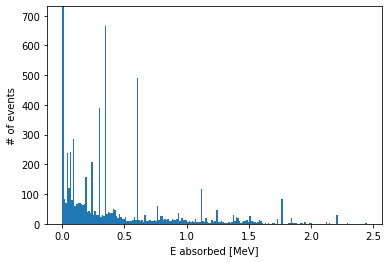

In [9]:
SimpleHistogram(data_U238_table["Energy"], do_texts=False)
plt.savefig("figures/U_238_table_simple_geom.svg", bbox_layout="tight")

In [286]:
#initial energy of photons
primary_energies = np.loadtxt("data/uranium_table_simple_detector/primary_energies.txt")
primary_energies = np.loadtxt("data/data_table_simple_geom_big/primaryEnergies.txt")

#### Generation validation

Mean absolute difference: 0.003%


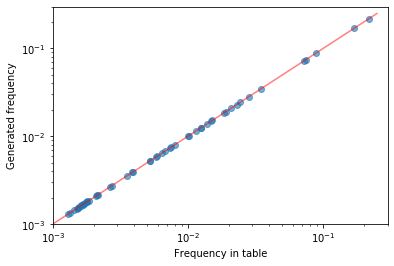

In [287]:
primary_numbers = np.unique(primary_energies, return_counts=True)[1]
primary_freq    = primary_numbers / sum(primary_numbers)

plt.scatter(table["Norm_prob"], primary_freq, alpha=0.6)
plt.plot([0, 0.25], [0, 0.25], color="red", alpha=0.5)

plt.xlabel("Frequency in table")
plt.ylabel("Generated frequency")

plt.yscale("log")
plt.xscale("log")
plt.ylim(0.001, 0.3)
plt.xlim(0.001, 0.3)

avg_diff = sum(abs(table["Norm_prob"] - primary_freq)) / len(table)
print ("Mean absolute difference: %.3f%%" % (avg_diff * 100))

plt.savefig("figures/table_simple_geom_big_frequency_check.svg", bbox_layout="tight")

## From simulation (RadioactiveDecay)

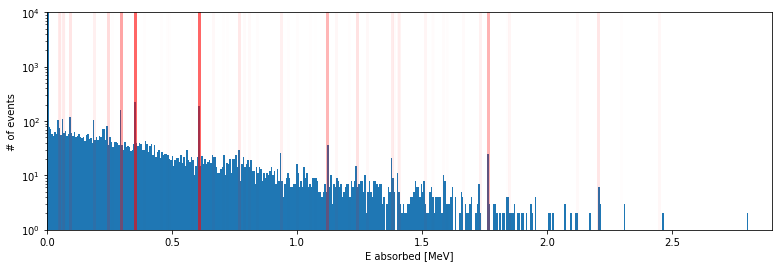

In [257]:
data_U238_decay_simple_geom = read_with_angle("data/decay_U238/")

plt.figure(figsize=(13,4))

for _, (isotope, E, P, P_norm) in table.iterrows():
    plt.axvline(E, color="red", alpha=min(P_norm*4, 0.6), linewidth=3)

SimpleHistogram(data_U238_decay_simple_geom["Energy"], bin_num=500, do_texts=False)
plt.yscale("log")
plt.ylim(1,10000)
plt.xlim(0, 2.9)

plt.savefig("figures/U_238_simdecay_simple_geom.svg", bbox_layout="tight")

# More realistic geometry created

default distance set to 5 cm (from detector, not crystal)

**from now on gamma particles are only generated with momentum towards the detector (on a half-sphere)**

**!!!!!**<br>
**don't forget that now the crystal is positioned at 0.5 cm, so distances are not compatible with previous ones<br>
I have initially forgotten this, these are the corrected results**

## U 238 table

In [279]:
data_table_simple_geom = read_with_angle("data/distance_table_simple_geom/5/", num_threads=8)
data_table_real_geom   = read_with_angle("data/uranium_table_real_geom/")

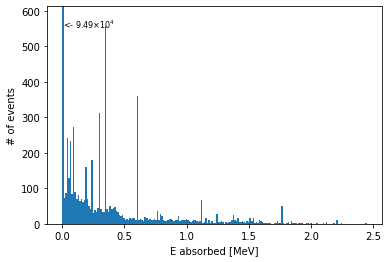

In [280]:
SimpleHistogram(data_table_real_geom["Energy"])
plt.savefig("figures/U_238_table_real_geom.svg", bbox_layout="tight")

#### Realistic vs simple cylinder geom

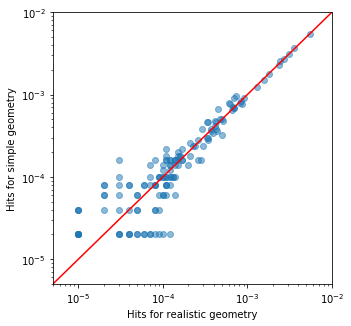

In [281]:
vals_real  , bins_real   = np.histogram(data_table_real_geom["Energy"]  , bins=200)
vals_simple, bins_simple = np.histogram(data_table_simple_geom["Energy"], bins=200)

#normalize
vals_real   = vals_real   / vals_real.sum()
vals_simple = vals_simple / vals_simple.sum()

plt.figure(figsize=(5,5))

plt.scatter(vals_real, vals_simple, alpha=0.5)

plt.xlabel("Hits for realistic geometry")
plt.ylabel("Hits for simple geometry")

plt.xscale("log")
plt.yscale("log")
plt.xlim(5e-6,1e-2)
plt.ylim(5e-6,1e-2)

plt.plot([0,600], [0, 600], color="red");

plt.savefig("figures/U_238_table_simple_vs_real_geom.svg", bbox_layout="tight")

## Monoenergetic gamma

In [16]:
data_mono_real_geom = read_with_angle("data/real_geom_monoenergetic_1MeV_5cm/")

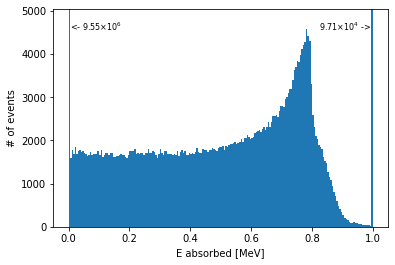

In [17]:
SimpleHistogram(data_mono_real_geom["Energy"])

same again...

## U238 simulated decay

In [27]:
data_simdecay_real_geom = read_with_angle("data/distance_simdecay_real_geom/5/")

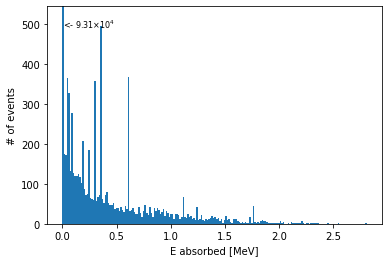

In [22]:
SimpleHistogram(data_simdecay_real_geom["Energy"])

#### RadioactiveDecay vs gamma Table - hits around table peaks

In [268]:
table_hits    = count_hit_ratio_around_peaks(data_table_simple_geom["Energy"])
simdecay_hits = count_hit_ratio_around_peaks(data_simdecay_real_geom["Energy"])

In [275]:
ratio = simdecay_hits[:, 1].sum() / table_hits[:, 1].sum()
print ("Ratio of peak hits: %.3f" % ratio)
print ()
print ("Note that table momentums are generated only on a half-sphere while simulated decay is isometric")
print ("Corrigated ratio: %.3f" % (ratio * 2))
print ("Sum probability from table: %.3f" % table["Probability"].sum())

Ratio of peak hits: 1.106

Note that table momentums are generated only on a half-sphere while simulated decay is isometric
Corrigated ratio: 2.213
Sum probability from table: 2.163


Note that the table is not complete. Only contains P(E) > 0.001

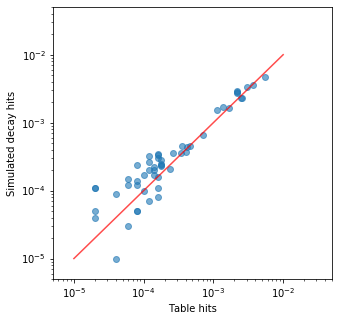

In [277]:
plt.figure(figsize=(5,5))

plt.scatter(table_hits[:, 1], simdecay_hits[:, 1], alpha=.6)

plt.plot([1e-5, 1e-2], [1e-5, 1e-2], color="red", alpha=0.7)

plt.xscale("log")
plt.xlim(0.000005, 0.05)
plt.yscale("log")
plt.ylim(0.000005, 0.05)

plt.xlabel("Table hits")
plt.ylabel("Simulated decay hits");

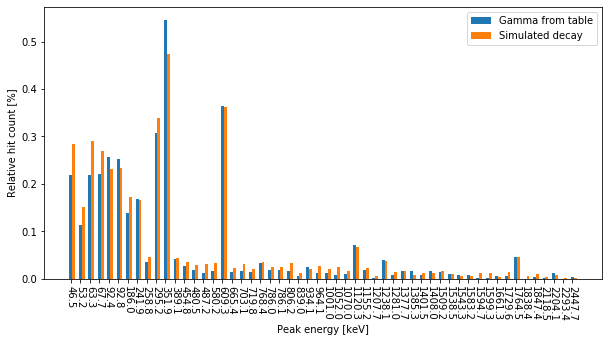

In [278]:
plt.figure(figsize=(10,5))

#x poition 0-len(table)
Xs     = np.arange(len(table))
#offset of 2nd bar plot
offset = 0.3

plt.bar(Xs,        table_hits[:, 1]    * 100, width=0.3, label="Gamma from table")
plt.bar(Xs+offset, simdecay_hits[:, 1] * 100, width=0.3, label="Simulated decay")

plt.xticks(rotation=-90)
plt.xticks(Xs, ["%.1f" % E for E in table["E_MeV"] * 1000])

plt.xlabel("Peak energy [keV]")
plt.ylabel("Relative hit count [%]")

plt.legend();

# Distance, geometry, generation type - hit counts per peak

In [16]:
dist_table_simple_geom    = read_distance_folders("data/distance_table_simple_geom",    dists=list(range(1,10)) + list(range(10, 21, 2)), num_threads=8)
dist_simdecay_simple_geom = read_distance_folders("data/distance_simdecay_simple_geom", dists=list(range(1,10)) + list(range(10, 21, 2)), num_threads=8)
dist_table_real_geom      = read_distance_folders("data/distance_table_real_geom",      dists=list(range(1,10)) + list(range(10, 21, 2)), num_threads=8)
dist_simdecay_real_geom   = read_distance_folders("data/distance_simdecay_real_geom",   dists=list(range(1,10)) + list(range(10, 21, 2)), num_threads=4)

### Simple vs real geometry in simulated decay

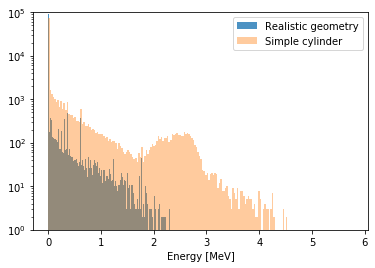

In [129]:
SimpleHistogram(dist_simdecay_real_geom[4]["Energy"],   do_texts=False, label="Realistic geometry", alpha=.8)
SimpleHistogram(dist_simdecay_simple_geom[4]["Energy"], do_texts=False, label="Simple cylinder",    alpha=.4)

plt.xlabel("Energy [MeV]")
plt.ylabel("")
plt.legend()

plt.yscale("log")
plt.ylim(1, 1e5);

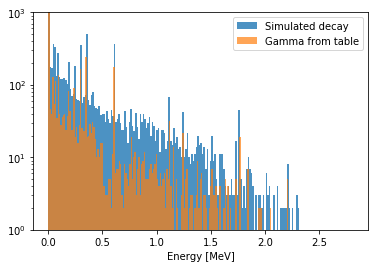

In [127]:
SimpleHistogram(dist_simdecay_real_geom[4]["Energy"], do_texts=False, label="Simulated decay",  alpha=0.8)
SimpleHistogram(dist_table_real_geom[4]["Energy"],    do_texts=False, label="Gamma from table", alpha=.7)

plt.xlabel("Energy [MeV]")
plt.ylabel("")
plt.legend()

plt.yscale("log")
plt.ylim(1, 1e3);

In [111]:
(dist_simdecay_real_geom[4]["Energy"] == 0).sum()

92965

In [113]:
(dist_table_real_geom[4]["Energy"] == 0).sum()*2

94718

large difference, probably due to *$e^-$* and all other stuff getting into the detector, not just photons

In [23]:
len(dist_simdecay_simple_geom[4]["Energy"])

100000

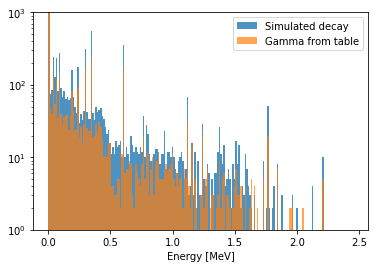

In [136]:
SimpleHistogram(data_geom_U238_table["Energy"],    do_texts=False, label="Simulated decay",  alpha=0.8)
SimpleHistogram(dist_table_real_geom[4]["Energy"], do_texts=False, label="Gamma from table", alpha=.7)

plt.xlabel("Energy [MeV]")
plt.ylabel("")
plt.legend()

plt.yscale("log")
plt.ylim(1, 1e3);